In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.getcwd()
os.chdir( "C:/Users/Miray/Desktop")
os.getcwd()

'C:\\Users\\Miray\\Desktop'

**Bu notebook'ta tüm classification modelleri uygulanmıştır. Dummy variable dönüşümü yapılmıştır.
Random Forest Sonrası feature azaltımı yapılmıştır (job ve reason değişkenleri) ardından MLP, SVM Boosting ve KNN ile Naive Bayes uygulanmıştıri tuning sonuçları en alt hücrede tüm modeller için verilmiştir.**

In [2]:

import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
finans=pd.read_csv("finans.csv")

In [4]:
hq=finans.copy()
df=hq.dropna()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018 entries, 153 to 3549
Data columns (total 13 columns):
bad        2018 non-null int64
loan       2018 non-null int64
mortdue    2018 non-null float64
value      2018 non-null float64
reason     2018 non-null object
job        2018 non-null object
yoj        2018 non-null float64
derog      2018 non-null float64
delinq     2018 non-null float64
clage      2018 non-null float64
ninq       2018 non-null float64
clno       2018 non-null float64
debtinc    2018 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 220.7+ KB


,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
153,0,18200,94727.0,136877.0,DebtCon,Mgr,15.0,0.0,0.0,168.96,2.0,26.0,36.056
154,0,21700,79240.0,96784.0,DebtCon,Mgr,5.0,0.0,0.0,64.51,6.0,24.0,38.079
155,0,34100,241931.0,36486.0,DebtCon,Mgr,1.0,0.0,2.0,196.01,3.0,50.0,42.459
156,0,8400,62989.0,76718.0,HomeImp,Mgr,3.0,0.0,2.0,131.47,0.0,22.0,29.200
157,0,17400,25859.0,43684.0,DebtCon,Mgr,16.0,1.0,0.0,95.36,1.0,17.0,27.108


In [5]:
dms=pd.get_dummies(df[['reason','job']])
dms.head()

,reason_DebtCon,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
153,1,0,1,0,0,0,0,0
154,1,0,1,0,0,0,0,0
155,1,0,1,0,0,0,0,0
156,0,1,1,0,0,0,0,0
157,1,0,1,0,0,0,0,0


In [6]:
y=df["bad"]
X_=df.drop(["bad","reason","job"],axis=1).astype("float64")
# X'in alacağı değerlerden kategorikleri ve hedef değişkeni sildik.
X_.head()

,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc
153,18200.0,94727.0,136877.0,15.0,0.0,0.0,168.96,2.0,26.0,36.056
154,21700.0,79240.0,96784.0,5.0,0.0,0.0,64.51,6.0,24.0,38.079
155,34100.0,241931.0,36486.0,1.0,0.0,2.0,196.01,3.0,50.0,42.459
156,8400.0,62989.0,76718.0,3.0,0.0,2.0,131.47,0.0,22.0,29.200
157,17400.0,25859.0,43684.0,16.0,1.0,0.0,95.36,1.0,17.0,27.108


In [7]:
X=pd.concat([X_,dms[["reason_HomeImp","job_Mgr","job_Office","job_Other","job_ProfEx","job_Sales","job_Self"]]],axis=1) #dummy haliyle concat yaparak bağımsız değişken dataframe'i oluşturduk.
X.head()

,loan,mortdue,value,yoj,derog,delinq,clage,ninq,clno,debtinc,reason_HomeImp,job_Mgr,job_Office,job_Other,job_ProfEx,job_Sales,job_Self
153,18200.0,94727.0,136877.0,15.0,0.0,0.0,168.96,2.0,26.0,36.056,0,1,0,0,0,0,0
154,21700.0,79240.0,96784.0,5.0,0.0,0.0,64.51,6.0,24.0,38.079,0,1,0,0,0,0,0
155,34100.0,241931.0,36486.0,1.0,0.0,2.0,196.01,3.0,50.0,42.459,0,1,0,0,0,0,0
156,8400.0,62989.0,76718.0,3.0,0.0,2.0,131.47,0.0,22.0,29.200,1,1,0,0,0,0,0
157,17400.0,25859.0,43684.0,16.0,1.0,0.0,95.36,1.0,17.0,27.108,0,1,0,0,0,0,0


In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 17), (505, 17), (1513,), (505,))

In [9]:
df["bad"].value_counts()

0    1840
1     178
Name: bad, dtype: int64

In [10]:
from sklearn.linear_model import LogisticRegression
loj=LogisticRegression(solver="liblinear")
loj_model=loj.fit(X_train,y_train)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
y_pred_train=loj_model.predict(X_train)

In [12]:
confusion_matrix(y_train,y_pred_train) 

array([[1370,    4],
       [ 139,    0]], dtype=int64)

In [13]:
y_pred=loj_model.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[465,   1],
       [ 39,   0]], dtype=int64)

In [14]:
accuracy_score(y_test,y_pred)

0.9207920792079208

In [15]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1374
           1       0.00      0.00      0.00       139

    accuracy                           0.91      1513
   macro avg       0.45      0.50      0.48      1513
weighted avg       0.82      0.91      0.86      1513



In [20]:
y_pred_test=loj_model.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       466
           1       0.00      0.00      0.00        39

    accuracy                           0.92       505
   macro avg       0.46      0.50      0.48       505
weighted avg       0.85      0.92      0.88       505



In [22]:
cross_val_score(loj_model,X_test,y_test, cv=10).mean()

0.922781112444978

In [23]:
from sklearn.tree import DecisionTreeClassifier

# CART Algorithm

In [24]:
cart=DecisionTreeClassifier()
cart_model=cart.fit(X_train,y_train)

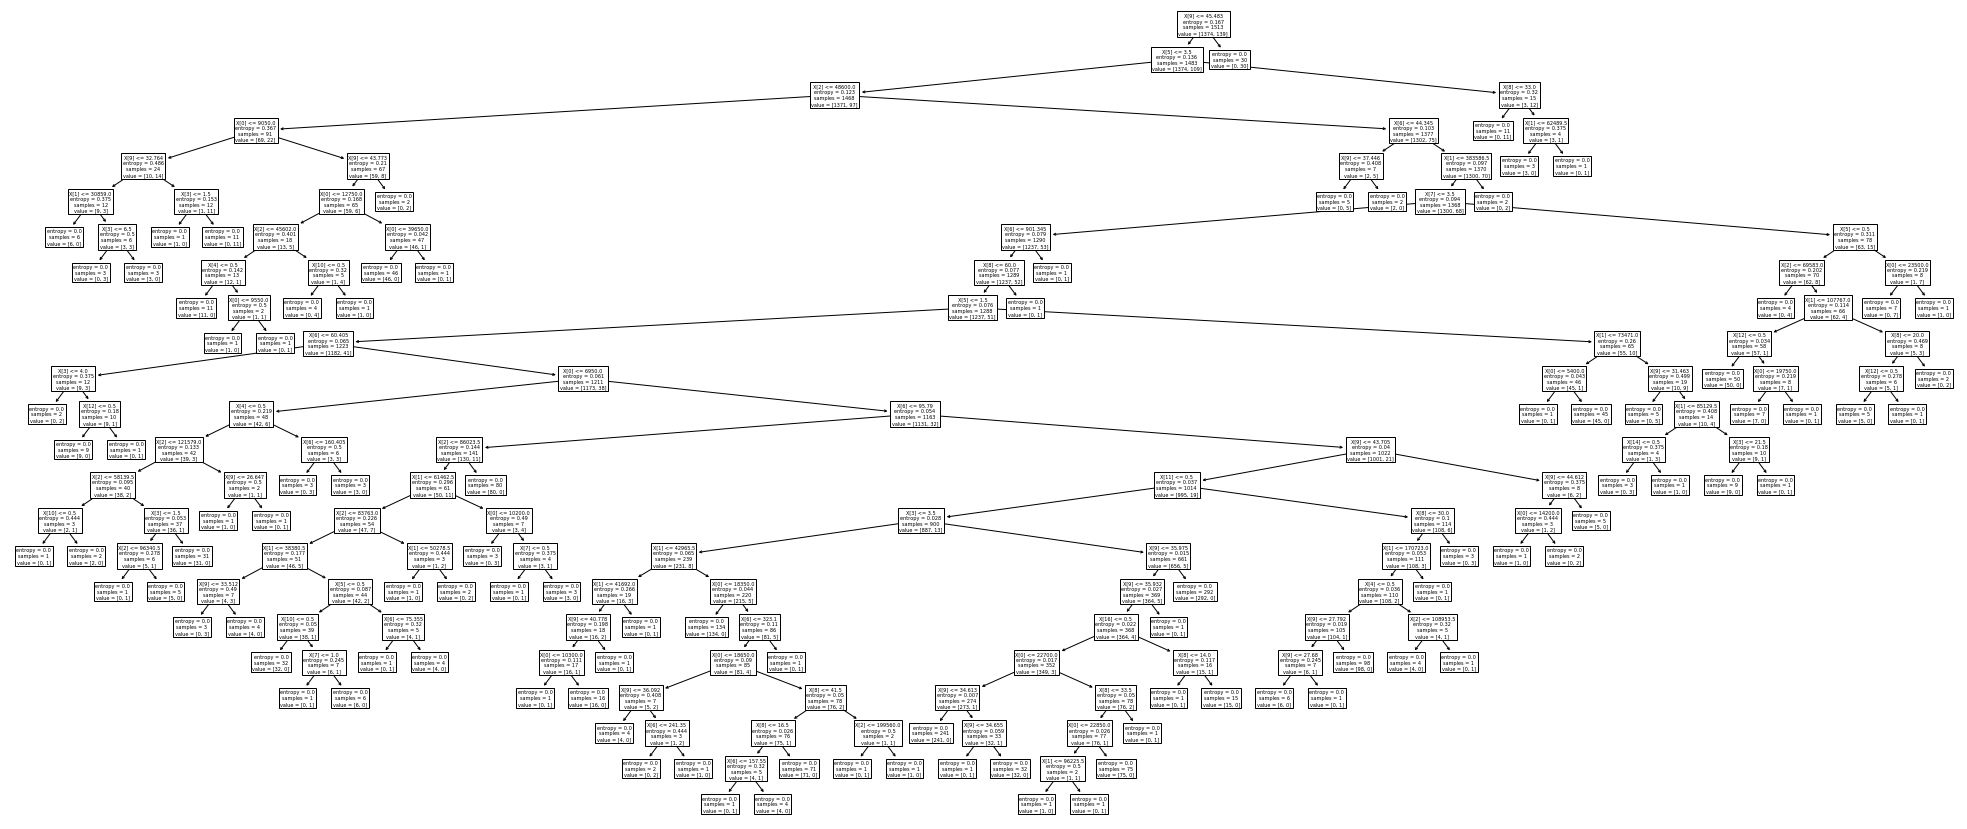

In [143]:
plt.figure(figsize=(35,15))
tree.plot_tree(cart_model);

In [25]:
y_pred_train2=cart_model.predict(X_train)

In [26]:
print("Train seti accuarcy:", accuracy_score(y_train,y_pred_train2))

Train seti accuarcy: 1.0


In [27]:
print("Train seti accuarcy:", accuracy_score(y_train,y_pred_train2))
print(classification_report(y_train,y_pred_train2))

Train seti accuarcy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1374
           1       1.00      1.00      1.00       139

    accuracy                           1.00      1513
   macro avg       1.00      1.00      1.00      1513
weighted avg       1.00      1.00      1.00      1513



In [28]:
y_pred=cart_model.predict(X_test)
print("Test seti accuarcy:", accuracy_score(y_test,y_pred))
print( classification_report(y_test,y_pred))

Test seti accuarcy: 0.9326732673267327
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       466
           1       0.58      0.46      0.51        39

    accuracy                           0.93       505
   macro avg       0.77      0.72      0.74       505
weighted avg       0.93      0.93      0.93       505



In [29]:
cart_grid={"max_depth": range(1,16),
          "min_samples_split" : list(range(10,20))}

In [31]:
cart=tree.DecisionTreeClassifier()
cart_cv=GridSearchCV(cart, cart_grid, cv=10, n_jobs= -1, verbose=2)
cart_cv_model= cart_cv.fit(X_train, y_train)

Fitting 10 folds for each of 490 candidates, totalling 4900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 4900 out of 4900 | elapsed:   29.7s finished


In [32]:
print("En iyi parametreler:" +str(cart_cv_model.best_params_))

En iyi parametreler:{'max_depth': 2, 'min_samples_split': 37}


In [33]:
cart=tree.DecisionTreeClassifier(max_depth=2, min_samples_split=37)
cart_tuned= cart.fit(X_train,y_train)

In [34]:
y_pred=cart_tuned.predict(X_test)
print("Tuning sonrası test accuracy score", accuracy_score(y_test,y_pred)) 
print( classification_report(y_test,y_pred))#tuning ile yükseldi.

Tuning sonrası test accuracy score 0.9425742574257425
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       466
           1       0.78      0.36      0.49        39

    accuracy                           0.94       505
   macro avg       0.86      0.68      0.73       505
weighted avg       0.94      0.94      0.93       505



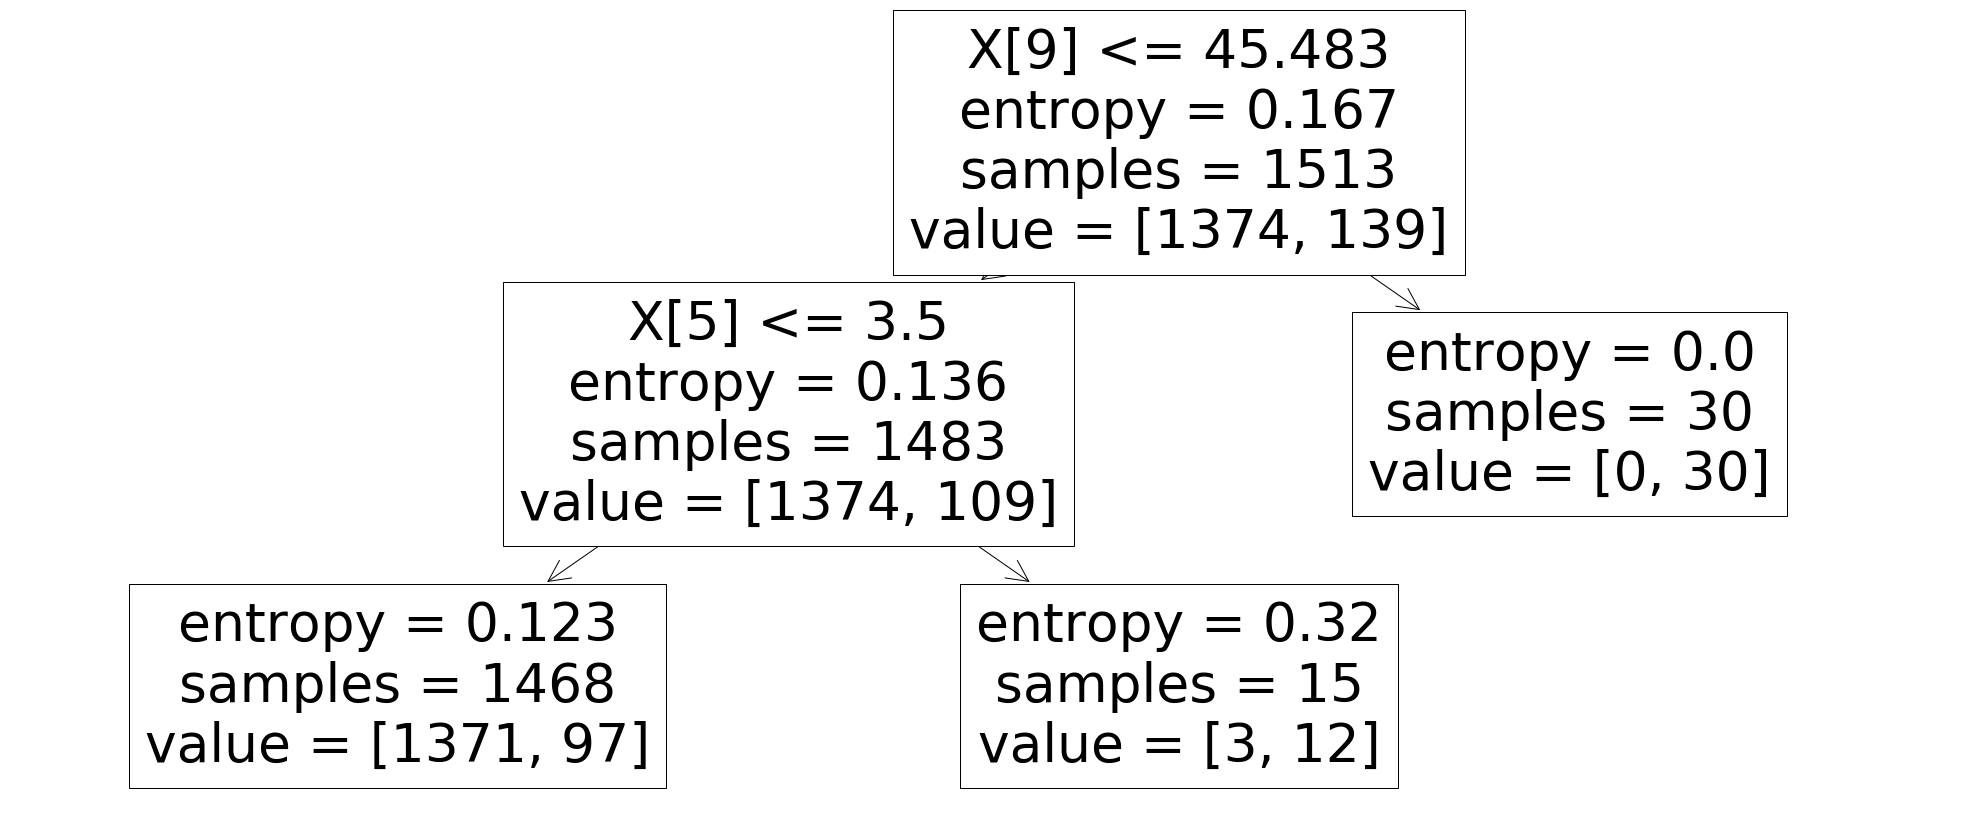

In [25]:
plt.figure(figsize=(35,15))
tree.plot_tree(cart_tuned);

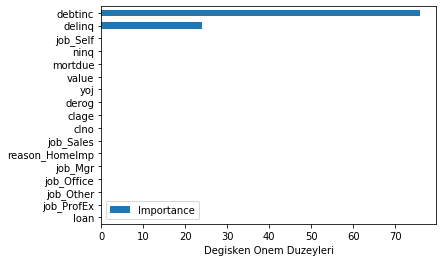

In [35]:
Importance = pd.DataFrame({"Importance": cart_tuned.feature_importances_*100},
                          index = X_train.columns)

Importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh")
plt.xlabel("Degisken Onem Duzeyleri")
plt.show()

# Random Forest Algorithm

In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 17), (505, 17), (1513,), (505,))

In [37]:
rf=RandomForestClassifier(random_state=42)
rf_model=rf.fit(X_train,y_train)

In [38]:
y_pred3=rf_model.predict(X_test)
print("Test Seti Random Forest Accuracy Score:", accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3),"Test veri seti için :")

Test Seti Random Forest Accuracy Score: 0.9524752475247524
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       466
           1       0.94      0.41      0.57        39

    accuracy                           0.95       505
   macro avg       0.95      0.70      0.77       505
weighted avg       0.95      0.95      0.94       505
 Test veri seti için :


In [39]:
rf_params={"max_depth": list(range(2,10)),
        "max_features": [2,5,17],
        "n_estimators": [10,20,50]}
rf_model = RandomForestRegressor(random_state=42)

rf_tuned = GridSearchCV(rf_model, 
                           rf_params, 
                           cv=10, 
                           n_jobs=-1, 
                           verbose=2)
rf_tuned.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   19.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8,

In [41]:
print("Random Forest en iyi parametre değerleri:",rf_tuned.best_params_)

Random Forest en iyi parametre değerleri: {'max_depth': 9, 'max_features': 5, 'n_estimators': 50}


In [42]:
rf_tuned=RandomForestClassifier(max_depth=9, max_features=5, n_estimators=50)
rf_tuned.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred=rf_tuned.predict(X_test)
print("Random Forest Tuning Sonrası Accuracy Değeri:", accuracy_score(y_test,y_pred))
print( classification_report(y_test,y_pred),"Test_tuned veri seti için")

Random Forest Tuning Sonrası Accuracy Değeri: 0.9524752475247524
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       466
           1       1.00      0.38      0.56        39

    accuracy                           0.95       505
   macro avg       0.98      0.69      0.77       505
weighted avg       0.95      0.95      0.94       505
 Test_tuned veri seti için


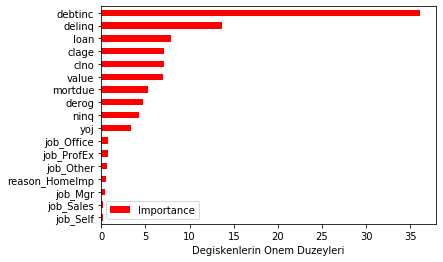

In [44]:
importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                          index=X_train.columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="r")
plt.xlabel("Degiskenlerin Onem Duzeyleri")
plt.show()

In [45]:
go = list(importance.sort_values(by= "Importance", axis=0,ascending=False)[0:10].T.columns)

In [46]:
go

['debtinc',
 'delinq',
 'loan',
 'clage',
 'clno',
 'value',
 'mortdue',
 'derog',
 'ninq',
 'yoj']

In [47]:
X=X[go]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [48]:
rf_tuned=RandomForestClassifier(max_depth=9, max_features=5, n_estimators=50)
rf_tuned.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
y_tuned=rf_tuned.predict(X_test)
print("Random Forest Tuning Sonrası Accuracy Değeri:", accuracy_score(y_test,y_tuned))
print( classification_report(y_test,y_tuned),"Test_tuned veri seti için")

Random Forest Tuning Sonrası Accuracy Değeri: 0.9584158415841584
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       0.95      0.49      0.64        39

    accuracy                           0.96       505
   macro avg       0.95      0.74      0.81       505
weighted avg       0.96      0.96      0.95       505
 Test_tuned veri seti için


# Yapay Sinir Ağı

In [173]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [174]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)

scaler.fit(X_test)
X_test= scaler.transform(X_test)

In [175]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,20)).fit(X_train, y_train)
mlp_model

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [176]:
y_pred_m=mlp_model.predict(X_test)
print("Yapay Sinir Ağı Accuracy Değeri:", accuracy_score(y_test,y_pred_m))

Yapay Sinir Ağı Accuracy Değeri: 0.9485148514851485


In [177]:
print(classification_report(y_test,y_pred_m))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       466
           1       0.76      0.49      0.59        39

    accuracy                           0.95       505
   macro avg       0.86      0.74      0.78       505
weighted avg       0.94      0.95      0.94       505



In [23]:
mlp_param = {"alpha": [0.1,0.01,0.02],
             "hidden_layer_sizes": [(100,50,150), (300,200,150)],
             "activation": ["relu","logistic"]}

mlp_cv_model = GridSearchCV(mlp_model, mlp_param, cv=10, n_jobs=-1, verbose=2)
mlp_cv_model.fit(X_train_scaled, y_train)

mlp_cv_model.best_params_


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.8min finished


{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (300, 200, 150)}

In [158]:
mlp_tuned =  MLPClassifier(alpha= 0.01, hidden_layer_sizes=(300,200,150), activation="relu")
mlp_tuned.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300, 200, 150), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [178]:
y_pred=mlp_tuned.predict(X_test)
print("Tuning Sonrası YSA Accuracy Değeri:", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Tuning Sonrası YSA Accuracy Değeri: 0.8455445544554455
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       466
           1       0.27      0.59      0.37        39

    accuracy                           0.85       505
   macro avg       0.62      0.73      0.64       505
weighted avg       0.91      0.85      0.87       505



# GARDIENT BOOSTING

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [181]:
X.head()

,debtinc,delinq,value,loan,clage,clno,mortdue,derog,ninq,yoj
153,36.056,0.0,136877.0,18200.0,168.96,26.0,94727.0,0.0,2.0,15.0
154,38.079,0.0,96784.0,21700.0,64.51,24.0,79240.0,0.0,6.0,5.0
155,42.459,2.0,36486.0,34100.0,196.01,50.0,241931.0,0.0,3.0,1.0
156,29.200,2.0,76718.0,8400.0,131.47,22.0,62989.0,0.0,0.0,3.0
157,27.108,0.0,43684.0,17400.0,95.36,17.0,25859.0,1.0,1.0,16.0


In [36]:
gb_model=GradientBoostingClassifier().fit(X_train,y_train)

In [157]:
y_pred=gb_model.predict(X_test)

In [31]:
accuracy_score(y_pred,y_test)

0.9584158415841584

In [32]:
print(classification_report(y_test,y_pred),"Test veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       0.95      0.49      0.64        39

    accuracy                           0.96       505
   macro avg       0.95      0.74      0.81       505
weighted avg       0.96      0.96      0.95       505
 Test veri seti için


# Gradient Boosting Tuned

In [44]:
gb_params={"learning_rate": [0.001,0.01,0.1],
           "n_estimators":[100,500,1000],
           "max_depth":[5,10],
           "min_samples_split":[5,10]}

gb=GradientBoostingClassifier()

gb_cv_model=GridSearchCV(gb,gb_params,cv=10,n_jobs=-1,verbose=2)


In [45]:
gb_cv_model.fit(X_train,y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort

In [46]:
print("En iyi parametreler:" + str(gb_cv_model.best_params_))

En iyi parametreler:{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 1000}


In [52]:
gb=GradientBoostingClassifier(learning_rate=0.1,
                             max_depth=10,
                             min_samples_split=10,
                             n_estimators=1000,)

In [56]:
gb_tuned=gb.fit(X_train,y_train)

In [57]:
y_pred=gb_tuned.predict(X_test)

In [58]:
accuracy_score(y_pred,y_test)

0.9643564356435643

In [59]:
print(classification_report(y_test,y_pred),"Test veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       0.96      0.56      0.71        39

    accuracy                           0.96       505
   macro avg       0.96      0.78      0.85       505
weighted avg       0.96      0.96      0.96       505
 Test veri seti için


# XGBOOSTING

In [60]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [61]:
from xgboost import XGBClassifier

In [62]:
xg_model=XGBClassifier().fit(X_train,y_train)

In [63]:
y_pred=xg_model.predict(X_test)

In [56]:
accuracy_score(y_pred,y_test)

0.9623762376237623

In [57]:
print(classification_report(y_test,y_pred),"Test veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       1.00      0.51      0.68        39

    accuracy                           0.96       505
   macro avg       0.98      0.76      0.83       505
weighted avg       0.96      0.96      0.96       505
 Test veri seti için


# XGB TUNED

In [58]:
xgb_params={"learning_rate": [0.001,0.01,0.1,0.2],
           "n_estimators":[500,1000],
           "max_depth":[5,10],
           "min_child_weight":[0.8,0.9]}
xgb=XGBClassifier()

xgb_cv_model=GridSearchCV(xgb,xgb_params,cv=10,n_jobs=-1,verbose=2)
xgb_cv_model.fit(X_train,y_train)


Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  4.3min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constra...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='war

In [59]:
print("En iyi parametreler:" + str(xgb_cv_model.best_params_))

En iyi parametreler:{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.8, 'n_estimators': 500}


In [64]:
xgb=XGBClassifier(learning_rate=0.1,
                             max_depth=5,
                             min_child_weight=0.8,
                             n_estimators=500,)


In [65]:
xgb_tuned=xgb.fit(X_train,y_train)

In [66]:
y_pred=xgb_tuned.predict(X_test)

In [67]:
accuracy_score(y_pred,y_test)

0.9663366336633663

In [64]:
print(classification_report(y_test,y_pred),"Test tuned veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       1.00      0.56      0.72        39

    accuracy                           0.97       505
   macro avg       0.98      0.78      0.85       505
weighted avg       0.97      0.97      0.96       505
 Test tuned veri seti için


# LGBoosting

In [68]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [69]:
from lightgbm import LGBMClassifier

In [50]:
lgb_model=LGBMClassifier().fit(X_train,y_train)

In [51]:
y_pred=lgb_model.predict(X_test)

In [171]:
accuracy_score(y_pred,y_test)

0.9643564356435643

In [172]:
print(classification_report(y_test,y_pred),"Test veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       1.00      0.54      0.70        39

    accuracy                           0.96       505
   macro avg       0.98      0.77      0.84       505
weighted avg       0.97      0.96      0.96       505
 Test veri seti için


In [52]:
lgb_params={"learning_rate": [0.001,0.01,0.1,0.2],
           "n_estimators":[500,1000],
           "max_depth":[4,6],
           "min_child_samples":[15,20],
           "subsample":[0.6,0.8],
           "importance_type":["gains","split"]}
lgb=LGBMClassifier()

lgb_cv_model=GridSearchCV(lgb,lgb_params,cv=10,n_jobs=-1,verbose=2)
lgb_cv_model.fit(X_train,y_train)


Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:  5.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lamb...ent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'importance_type': ['gains', 'split'],
                         'lea

In [55]:
print("En iyi parametreler:" + str(lgb_cv_model.best_params_))

En iyi parametreler:{'importance_type': 'gains', 'learning_rate': 0.2, 'max_depth': 4, 'min_child_samples': 20, 'n_estimators': 500, 'subsample': 0.6}


In [70]:
lgb=LGBMClassifier(learning_rate=0.2,
                             max_depth=4,
                             min_child_samples=20,
                             n_estimators=500,
                  subsample=0.6,
                  importance_type='gains')
lgb_tuned=lgb.fit(X_train,y_train)
y_pred=lgb_tuned.predict(X_test)
accuracy_score(y_pred,y_test)


0.9643564356435643

In [141]:
print(classification_report(y_test,y_pred),"Test tuned veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       1.00      0.54      0.70        39

    accuracy                           0.96       505
   macro avg       0.98      0.77      0.84       505
weighted avg       0.97      0.96      0.96       505
 Test tuned veri seti için


# CATBOOSTING

In [71]:
from catboost import CatBoostClassifier

In [72]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [74]:
cat=CatBoostClassifier().fit(X_train,y_train)
y_pred=cat.predict(X_test)
accuracy_score(y_pred,y_test)

Learning rate set to 0.012295
0:	learn: 0.6792570	total: 58.4ms	remaining: 58.3s
1:	learn: 0.6658778	total: 62ms	remaining: 30.9s
2:	learn: 0.6524563	total: 65.6ms	remaining: 21.8s
3:	learn: 0.6397816	total: 69.2ms	remaining: 17.2s
4:	learn: 0.6255691	total: 72.2ms	remaining: 14.4s
5:	learn: 0.6127910	total: 75.4ms	remaining: 12.5s
6:	learn: 0.6006439	total: 78.7ms	remaining: 11.2s
7:	learn: 0.5900509	total: 82.3ms	remaining: 10.2s
8:	learn: 0.5796807	total: 85.8ms	remaining: 9.45s
9:	learn: 0.5688533	total: 89.3ms	remaining: 8.84s
10:	learn: 0.5590471	total: 92.7ms	remaining: 8.34s
11:	learn: 0.5497403	total: 96.2ms	remaining: 7.92s
12:	learn: 0.5401475	total: 99.8ms	remaining: 7.57s
13:	learn: 0.5307893	total: 103ms	remaining: 7.29s
14:	learn: 0.5213330	total: 107ms	remaining: 7.03s
15:	learn: 0.5139298	total: 111ms	remaining: 6.82s
16:	learn: 0.5051855	total: 115ms	remaining: 6.63s
17:	learn: 0.4965126	total: 118ms	remaining: 6.46s
18:	learn: 0.4882481	total: 122ms	remaining: 6.3s
1

0.9663366336633663

In [73]:
accuracy_score(y_pred,y_test)

0.9643564356435643

In [178]:
print(classification_report(y_test,y_pred),"Test veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       1.00      0.54      0.70        39

    accuracy                           0.96       505
   macro avg       0.98      0.77      0.84       505
weighted avg       0.97      0.96      0.96       505
 Test veri seti için


In [100]:
cat_params={"learning_rate": [0.001,0.01,0.1],
           "iterations":[200,300],
           "depth":[5,10],
           "grow_policy":["Lossguide"],
           
           }
cat_m=CatBoostClassifier()

cat_cv_model=GridSearchCV(cat,cat_params,cv=10,n_jobs=-1,verbose=2)
cat_cv_model.fit(X_train,y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished


0:	learn: 0.5962647	total: 10.1ms	remaining: 2.02s
1:	learn: 0.5261789	total: 16.3ms	remaining: 1.61s
2:	learn: 0.4620211	total: 22.2ms	remaining: 1.46s
3:	learn: 0.4108901	total: 29.2ms	remaining: 1.43s
4:	learn: 0.3680686	total: 36.1ms	remaining: 1.41s
5:	learn: 0.3375173	total: 43.4ms	remaining: 1.4s
6:	learn: 0.3086747	total: 49.9ms	remaining: 1.38s
7:	learn: 0.2860756	total: 63ms	remaining: 1.51s
8:	learn: 0.2685416	total: 72.3ms	remaining: 1.53s
9:	learn: 0.2489026	total: 83.3ms	remaining: 1.58s
10:	learn: 0.2320233	total: 95.2ms	remaining: 1.64s
11:	learn: 0.2226509	total: 102ms	remaining: 1.6s
12:	learn: 0.2135469	total: 109ms	remaining: 1.57s
13:	learn: 0.1992477	total: 117ms	remaining: 1.55s
14:	learn: 0.1924340	total: 125ms	remaining: 1.54s
15:	learn: 0.1841781	total: 133ms	remaining: 1.53s
16:	learn: 0.1787920	total: 140ms	remaining: 1.5s
17:	learn: 0.1725615	total: 147ms	remaining: 1.49s
18:	learn: 0.1659796	total: 155ms	remaining: 1.48s
19:	learn: 0.1590274	total: 162ms	r

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x00000249EB8703C8>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [5, 10], 'grow_policy': ['Lossguide'],
                         'iterations': [200, 300],
                         'learning_rate': [0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [101]:
print("En iyi parametreler:" + str(cat_cv_model.best_params_))

En iyi parametreler:{'depth': 10, 'grow_policy': 'Lossguide', 'iterations': 200, 'learning_rate': 0.1}


In [74]:
cat=CatBoostClassifier(learning_rate=0.1,
                             depth=10,
                             iterations=200,
                  grow_policy= 'Lossguide' )
cat_tuned=cat.fit(X_train,y_train)
y_pred=cat_tuned.predict(X_test)
accuracy_score(y_pred,y_test)

0:	learn: 0.5894295	total: 57.2ms	remaining: 11.4s
1:	learn: 0.5203904	total: 62.8ms	remaining: 6.22s
2:	learn: 0.4539324	total: 69ms	remaining: 4.53s
3:	learn: 0.4037434	total: 75.3ms	remaining: 3.69s
4:	learn: 0.3639042	total: 81.3ms	remaining: 3.17s
5:	learn: 0.3354228	total: 86.8ms	remaining: 2.81s
6:	learn: 0.3032962	total: 94.6ms	remaining: 2.61s
7:	learn: 0.2769662	total: 101ms	remaining: 2.42s
8:	learn: 0.2584855	total: 110ms	remaining: 2.34s
9:	learn: 0.2451999	total: 118ms	remaining: 2.23s
10:	learn: 0.2323635	total: 126ms	remaining: 2.16s
11:	learn: 0.2224129	total: 135ms	remaining: 2.12s
12:	learn: 0.2112801	total: 147ms	remaining: 2.11s
13:	learn: 0.2047314	total: 156ms	remaining: 2.07s
14:	learn: 0.1961849	total: 162ms	remaining: 2s
15:	learn: 0.1886937	total: 170ms	remaining: 1.95s
16:	learn: 0.1803083	total: 177ms	remaining: 1.9s
17:	learn: 0.1728333	total: 184ms	remaining: 1.86s
18:	learn: 0.1674309	total: 192ms	remaining: 1.82s
19:	learn: 0.1660197	total: 198ms	remain

0.9603960396039604

In [61]:
print(classification_report(y_test,y_pred),"Test tuned veri seti için")

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       466
           1       1.00      0.51      0.68        39

    accuracy                           0.96       505
   macro avg       0.98      0.76      0.83       505
weighted avg       0.96      0.96      0.96       505
 Test tuned veri seti için


# Naive Bayes

In [75]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [76]:
from sklearn.naive_bayes import GaussianNB

In [85]:
nb=GaussianNB()
nb_model=nb.fit(X_train,y_train)
nb_model

GaussianNB(priors=None, var_smoothing=1e-09)

In [86]:
nb_model.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [ ]:
y_pred=nb_model.predict(X_test)

In [87]:
accuracy_score (y_test,y_pred)

0.9623762376237623

In [95]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       466
           1       0.10      0.03      0.04        39

    accuracy                           0.91       505
   macro avg       0.51      0.50      0.50       505
weighted avg       0.86      0.91      0.88       505



In [88]:
cross_val_score(nb_model, X_test,y_test,cv=10).mean()

0.9307418967587034

In [77]:
from sklearn.naive_bayes import BernoulliNB

In [78]:
bnb=BernoulliNB()
bnb_model=bnb.fit(X_train,y_train)
bnb_model

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [79]:
y_pred=bnb_model.predict(X_test)

In [80]:
accuracy_score (y_test,y_pred)

0.906930693069307

In [97]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       466
           1       0.10      0.03      0.04        39

    accuracy                           0.91       505
   macro avg       0.51      0.50      0.50       505
weighted avg       0.86      0.91      0.88       505



In [93]:
cross_val_score(nb_model, X_test,y_test,cv=10).mean()

0.9307418967587034

# SVM

In [81]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [80]:
svm_model=SVC(kernel="linear").fit(X_train,y_train)

In [99]:
svm_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [82]:
y_pred=svm_model.predict(X_test)

In [101]:
accuracy_score(y_test,y_pred)

0.9287128712871288

In [102]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       466
           1       1.00      0.08      0.14        39

    accuracy                           0.93       505
   macro avg       0.96      0.54      0.55       505
weighted avg       0.93      0.93      0.90       505



In [104]:
svc_params={"C":np.arange(1,10)}
svc=SVC(kernel="linear")
svc_tuned=GridSearchCV(svc,svc_params,
                         cv=10,n_jobs=-1,
                         verbose=2)
svc_tuned.fit(X_train,y_train)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 74.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 173.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [105]:
print("En iyi parametreler:" + str(svc_tuned.best_params_))

En iyi parametreler:{'C': 3}


In [83]:
svc_tuned=SVC(C=3,kernel="linear").fit(X_train,y_train)

In [84]:
y_pred=svc_tuned.predict(X_test)

In [85]:
accuracy_score(y_test,y_pred)

0.9287128712871288

In [113]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       466
           1       0.83      0.13      0.22        39

    accuracy                           0.93       505
   macro avg       0.88      0.56      0.59       505
weighted avg       0.92      0.93      0.91       505



# KNN

In [86]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1513, 10), (505, 10), (1513,), (505,))

In [87]:
knn=KNeighborsClassifier()
knn_model=knn.fit(X_train,y_train)
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [88]:
y_pred=knn_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.9227722772277228

In [117]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       466
           1       0.50      0.10      0.17        39

    accuracy                           0.92       505
   macro avg       0.71      0.55      0.56       505
weighted avg       0.90      0.92      0.90       505



# KNN TUNED

In [122]:
knn_params={"n_neighbors":np.arange(1,10)}
knn=KNeighborsClassifier()
knn_tuned=GridSearchCV(knn,knn_params,cv=10)
knn_tuned.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [123]:
print("En iyi parametreler:" + str(knn_tuned.best_params_))

En iyi parametreler:{'n_neighbors': 8}


In [89]:
knn=KNeighborsClassifier(8)
knn_tuned=knn.fit(X_train,y_train)
y_pred=knn_tuned.predict(X_test)
accuracy_score(y_test,y_pred)


0.9267326732673268

In [90]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       466
           1       0.75      0.08      0.14        39

    accuracy                           0.93       505
   macro avg       0.84      0.54      0.55       505
weighted avg       0.91      0.93      0.90       505



In [92]:
modeller=[
    
    rf_tuned,
    svc_tuned,
    cat_tuned,
    lgb_tuned,
    xgb_tuned,
    gb_tuned,
    bnb_model,
    knn_tuned,
]
for model in modeller:
    isimler=model.__class__.__name__
    y_pred=model.predict(X_test)
    dogruluk=accuracy_score(y_test,y_pred)
    print("-"*28)
    print(isimler +":")
    print("Accuracy: {:.4%}".format(dogruluk))

----------------------------
RandomForestClassifier:
Accuracy: 95.8416%
----------------------------
SVC:
Accuracy: 92.8713%
----------------------------
CatBoostClassifier:
Accuracy: 96.0396%
----------------------------
LGBMClassifier:
Accuracy: 96.4356%
----------------------------
XGBClassifier:
Accuracy: 96.6337%
----------------------------
GradientBoostingClassifier:
Accuracy: 96.4356%
----------------------------
BernoulliNB:
Accuracy: 90.6931%
----------------------------
KNeighborsClassifier:
Accuracy: 92.6733%
